In [216]:
import torch
import json
import os

import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import mediapipe as mp
import pandas as pd
import numpy as np

from tqdm import tqdm; tqdm.pandas();

# Selecting a device for training

In [217]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Current device:", device)

Current device: cuda


# Settings

In [218]:
# File directories
DATA_DIR       = '/kaggle/input/asl-signs/'
LANDMARK_FILES = 'train_landmark_files'
CSV_FILE       = 'train.csv'
ID_TO_SIGN_MAP = 'sign_to_prediction_index_map.json'

# Distribution of classes in the dataset

In [220]:
parquets = pd.read_csv(os.path.join(DATA_DIR, CSV_FILE))
parquets.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


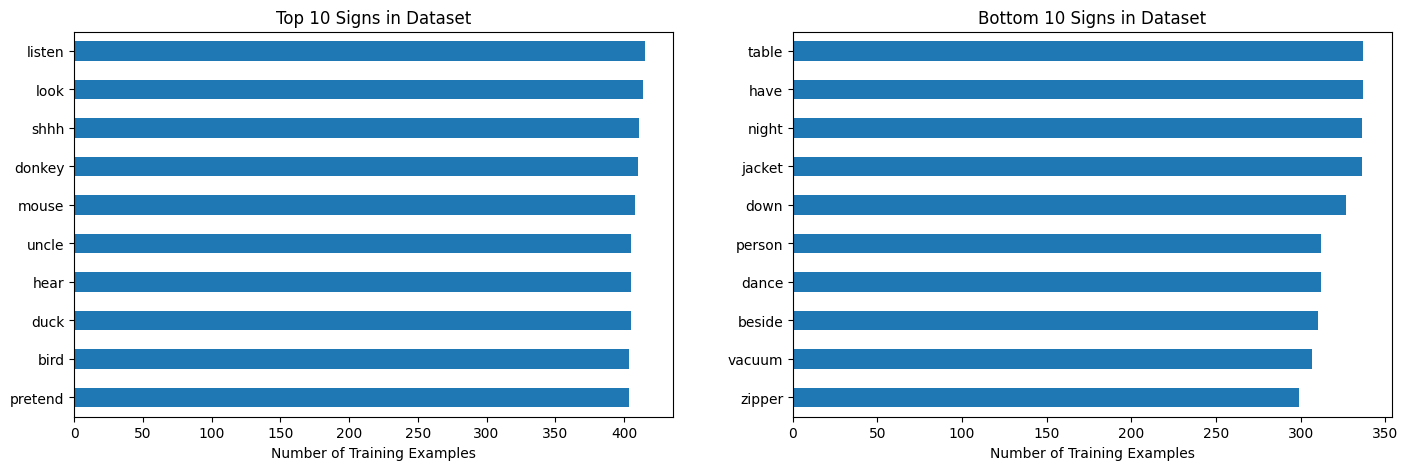

In [221]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (17, 5))

parquets['sign'].value_counts().head(10).sort_values(ascending = True).plot(
    kind = "barh", ax = ax1, title = 'Top 10 Signs in Dataset'
)

parquets['sign'].value_counts().tail(10).sort_values(ascending = True).plot(
    kind = "barh", ax = ax2, title = 'Bottom 10 Signs in Dataset'
)

ax1.set_xlabel('Number of Training Examples')
ax2.set_xlabel('Number of Training Examples')

plt.show()

# Class indexes

In [ ]:
def read_json(path):
    
    with open(path, "r") as file:
        json_data = json.load(file)
        
    return json_data

In [ ]:
sign_2_id_map = read_json(os.path.join(DATA_DIR, ID_TO_SIGN_MAP))
id_2_sign_map = {id: sign for sign, id in sign_2_id_map.items()}

In [ ]:
parquets['id'] = parquets["sign"].map(lambda sign: sign_2_id_map[sign])

# Landmark data example

In [225]:
df = pq.read_table(EXAMPLE_DIR).to_pandas()
df.head()

,frame,row_id,type,landmark_index,x,y,z
0,17,17-face-0,face,0,0.503836,0.500633,-0.043933
1,17,17-face-1,face,1,0.497457,0.471682,-0.064423
2,17,17-face-2,face,2,0.500418,0.482863,-0.038524
3,17,17-face-3,face,3,0.487654,0.446823,-0.039804
4,17,17-face-4,face,4,0.496760,0.463060,-0.066302


In [226]:
df = pq.read_table(EXAMPLE_DIR).to_pandas().dropna()
df = df.drop(columns = ['row_id'], axis = 1)
df = pd.get_dummies(df, columns = ['type'], prefix = '', prefix_sep = '')
df.head()

,frame,landmark_index,x,y,z,face,pose,right_hand
0,17,0,0.503836,0.500633,-0.043933,1,0,0
1,17,1,0.497457,0.471682,-0.064423,1,0,0
2,17,2,0.500418,0.482863,-0.038524,1,0,0
3,17,3,0.487654,0.446823,-0.039804,1,0,0
4,17,4,0.496760,0.463060,-0.066302,1,0,0


# Visualization of Landmarks

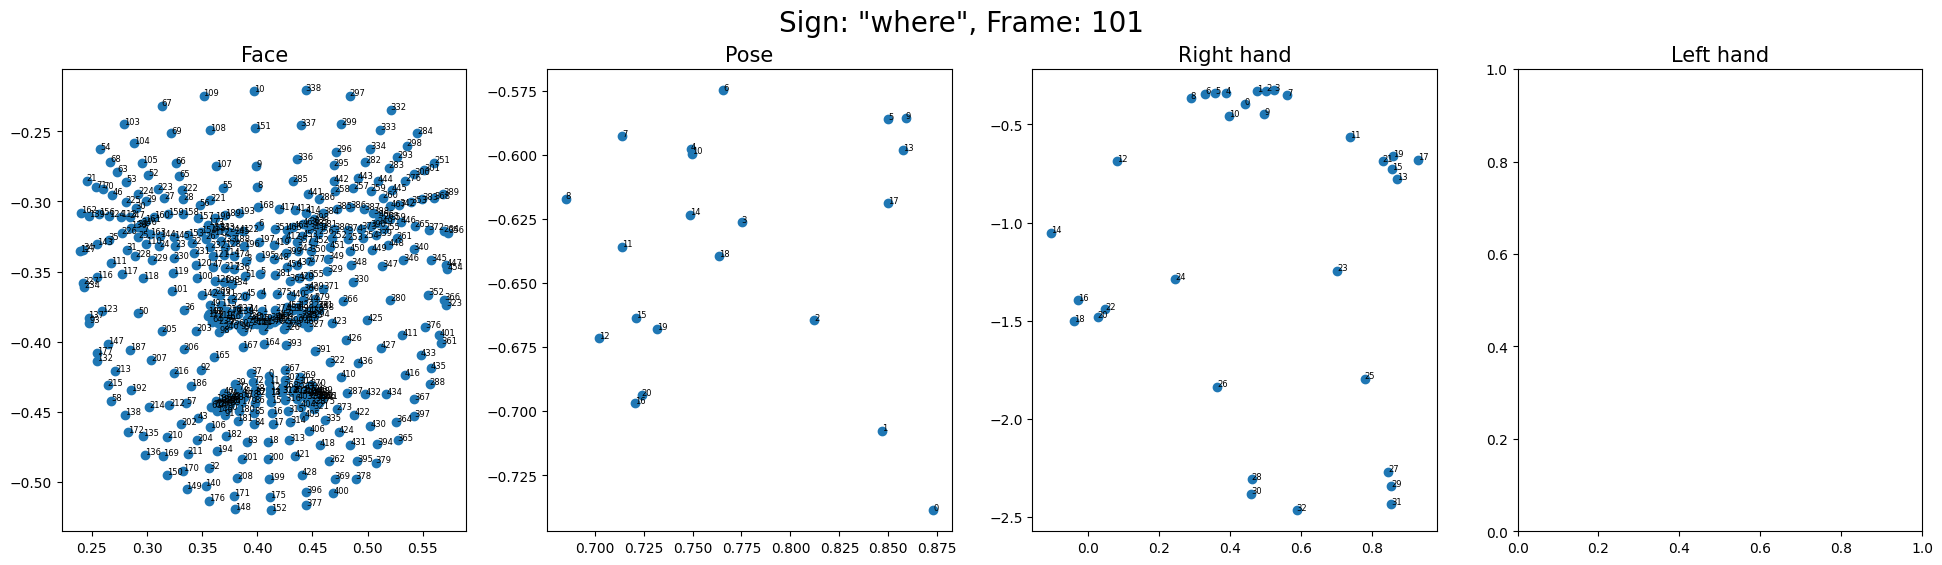

In [231]:
def show_frame(frame, label, frame_num):
    
    fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize = (24, 6))

    face_lm  = frame[frame[:, 5] == 1]
    pose_lm  = frame[frame[:, 6] == 1]
    right_lm = frame[frame[:, 7] == 1]

    ax1.set_title('Face', fontsize = 15)
    ax2.set_title('Pose', fontsize = 15)
    ax3.set_title('Right hand', fontsize = 15)
    ax4.set_title('Left hand', fontsize = 15)

    ax1.scatter(face_lm[:, 2], -face_lm[:, 3])
    ax2.scatter(pose_lm[:, 2], -pose_lm[:, 3])
    ax3.scatter(right_lm[:, 2], -right_lm[:, 3])

    for _, lm_id, x, y, _, _, _, _ in face_lm:
        ax1.text(x, -y, int(lm_id), fontsize = 6)

    for _, lm_id, x, y, _, _, _, _ in pose_lm:
        ax2.text(x, -y, int(lm_id), fontsize = 6)

    for _, lm_id, x, y, _, _, _, _ in right_lm:
        ax3.text(x, -y, int(lm_id), fontsize = 6)

    fig.suptitle(f'Sign: "{label}", Frame: {frame_num}', fontsize = 20)
    plt.show()